<a href="https://colab.research.google.com/github/fangzhongfionaxu/AIT-DeepLearning-Project/blob/sadichchha/Final%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Exploration

## Data Preprocessing

In [1]:
import os
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import when, regexp_extract, coalesce, col, lit
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
import holidays
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Set up & Load raw data
spark = SparkSession.builder.appName("FlightPreprocessing").getOrCreate()

df = spark.read.csv("./Data/itineraries.csv", header=True, inferSchema=True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/27 13:16:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
# Data cleaning & Feature engineering
columns_to_drop = [
    'legId', 'totalFare', 'elapsedDays', 'fareBasisCode',
    'segmentsAirlineCode', 'segmentsDepartureTimeEpochSeconds',
    'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalAirportCode',
    'segmentsDepartureAirportCode', 'segmentsEquipmentDescription', 'segmentsDistance'
]

df = df.drop(*columns_to_drop)

# isCoach
flight_clean = df.withColumn(
    'isCoach', F.when(F.col('segmentsCabinCode').contains('coach'), 1).otherwise(0)
).drop('segmentsCabinCode')

# days_until_flight
flight_clean = flight_clean.withColumn(
    'days_until_flight', F.datediff(F.to_date('flightDate'), F.to_date('searchDate'))
)

# holiday/weekend
us_holidays = holidays.US(years=2024)
holiday_dates = [d.strftime("%Y-%m-%d") for d in us_holidays]
flight_clean = flight_clean.withColumn("isHoliday", F.when(F.col("flightDate").isin(holiday_dates), 1).otherwise(0))
flight_clean = flight_clean.withColumn("isWeekend", F.when(F.dayofweek("flightDate").isin([1, 7]), 1).otherwise(0))

# Fill missing distance
flight_clean = flight_clean.withColumn(
    "totalTravelDistance",
    when(col("totalTravelDistance").rlike("^[0-9.]+$"), col("totalTravelDistance").cast("float"))
    .otherwise(None)
)
median_distance = flight_clean.approxQuantile("totalTravelDistance", [0.5], 0.01)[0]
flight_clean = flight_clean.fillna({"totalTravelDistance": median_distance})

# Extract travel minutes
flight_clean = flight_clean.withColumn(
    "hours",
    coalesce(regexp_extract(col("travelDuration"), r"(\d+)H", 1).cast("int"), lit(0))
).withColumn(
    "minutes",
    coalesce(regexp_extract(col("travelDuration"), r"(\d+)M", 1).cast("int"), lit(0))
)
flight_clean = flight_clean.withColumn(
    "travelMinutes",
    col("hours") * 60 + col("minutes")
)
flight_clean = flight_clean.drop('travelDuration')

# isNonstop
flight_clean = flight_clean.withColumn("segmentsDurationArray", F.split("segmentsDurationInSeconds", r"\\|\\|"))\
    .withColumn("isNonstop", F.when(F.size("segmentsDurationArray") == 1, 1).otherwise(0))\
    .drop("segmentsDurationArray", "segmentsDurationInSeconds")

In [ ]:
# Temporal sort
flight_clean = flight_clean.withColumn("departure_ts", F.to_timestamp("segmentsDepartureTimeRaw"))\
    .withColumn("departure_date", F.to_date("departure_ts"))\
    .orderBy("departure_date")

dates = flight_clean.select("departure_date").distinct().orderBy("departure_date")
total_dates = dates.count()
train_end_idx = int(total_dates * 0.7)
val_end_idx = train_end_idx + int(total_dates * 0.15)

train_dates = dates.limit(train_end_idx).collect()
val_dates = dates.limit(val_end_idx).tail(val_end_idx - train_end_idx)
test_dates = dates.tail(total_dates - val_end_idx)

train_cutoff = train_dates[-1]["departure_date"]
val_cutoff = val_dates[-1]["departure_date"]

train_df = flight_clean.filter(F.col("departure_date") <= train_cutoff)
val_df = flight_clean.filter((F.col("departure_date") > train_cutoff) & (F.col("departure_date") <= val_cutoff))
test_df = flight_clean.filter(F.col("departure_date") > val_cutoff)

In [ ]:
# Encoding pipeline
binary_cols = ["isBasicEconomy", "isRefundable", "isNonstop", "isCoach", "isWeekend", "isHoliday"]
for colname in binary_cols:
    train_df = train_df.withColumn(colname, F.col(colname).cast("int"))
    val_df = val_df.withColumn(colname, F.col(colname).cast("int"))
    test_df = test_df.withColumn(colname, F.col(colname).cast("int"))

categorical_cols = ["startingAirport", "destinationAirport", "segmentsAirlineName"]
numerical_cols = ["seatsRemaining", "totalTravelDistance", "travelMinutes"]

indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_vec") for col in categorical_cols]
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="num_features")
scaler = MinMaxScaler(inputCol="num_features", outputCol="scaled_num_features")

pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler])
pipeline_model = pipeline.fit(train_df)

In [ ]:
# Chunked transformation & Save
base_dir = os.getcwd()

os.makedirs(os.path.join(base_dir, "chunks", "train"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "chunks", "val"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "chunks", "test"), exist_ok=True)

train_output_path = os.path.join(base_dir, "chunks", "train")
val_output_path = os.path.join(base_dir, "chunks", "val")
test_output_path = os.path.join(base_dir, "chunks", "test")

In [ ]:
def transform_and_save_chunks(df, name_prefix, pipeline_model, chunk_size, output_dir):
    df = df.orderBy("departure_date")
    dates = df.select("departure_date").distinct().orderBy("departure_date")
    total_dates = dates.count()

    for start in range(0, total_dates, chunk_size):
        end = min(start + chunk_size, total_dates)
        date_range = dates.limit(end).tail(chunk_size)
        date_values = [row['departure_date'] for row in date_range]

        chunk_df = df.filter(F.col("departure_date").isin(date_values)).dropna(subset=["travelMinutes"])
        transformed = pipeline_model.transform(chunk_df)
        to_drop = [col + "_index" for col in categorical_cols] + ["num_features"]
        transformed = transformed.drop(*to_drop)

        output_path = os.path.join(output_dir, f"{name_prefix}_chunk_{start}_{end}.parquet")
        transformed.write.mode("overwrite").parquet(output_path)
        print(f"Saved: {output_path}")

In [ ]:
transform_and_save_chunks(train_df, "train", pipeline_model, chunk_size=50, output_dir=train_output_path)
transform_and_save_chunks(val_df, "val", pipeline_model, chunk_size=50, output_dir=val_output_path)
transform_and_save_chunks(test_df, "test", pipeline_model, chunk_size=50, output_dir=test_output_path)

In [ ]:
class ChunkedFlightGenerator(Sequence):
    def __init__(self, chunk_paths, batch_size=32, target_col="baseFare", vector_size=10):
        self.chunk_paths = chunk_paths
        self.batch_size = batch_size
        self.target_col = target_col
        self.vector_size = vector_size

        # Load all data
        self.data = pd.concat([pd.read_parquet(path) for path in chunk_paths], ignore_index=True)

        # Extract 3 datetime-based features
        self.data = self._extract_datetime_features(self.data)

        # Drop raw string and datetime columns
        columns_to_drop = [
            'searchDate', 'flightDate', 'departure_ts',
            'startingAirport', 'destinationAirport',
            'segmentsDepartureTimeRaw', 'segmentsArrivalTimeRaw',
            'segmentsAirlineName', 'departure_date'
        ]
        self.data.drop(columns=[col for col in columns_to_drop if col in self.data.columns], inplace=True)

        # Vector columns to expand
        self.vec_columns = [
            'startingAirport_vec',
            'destinationAirport_vec',
            'segmentsAirlineName_vec',
            'scaled_num_features'
        ]
        vec_expansions = [self._expand_vector_column(col) for col in self.vec_columns if col in self.data.columns]
        self.data.drop(columns=self.vec_columns, inplace=True, errors='ignore')

        # Numeric features (excluding target)
        numeric_df = self.data.drop(columns=[self.target_col])
        final_df = pd.concat([numeric_df] + vec_expansions, axis=1)

        print(list(final_df.columns))

        # Final features and targets
        self.X = final_df.astype(np.float32).values
        self.y = self.data[self.target_col].astype(np.float32).values

    def _expand_vector_column(self, col_name):
        """Expands a column of lists/vectors into multiple float32 columns."""
        # Fill NaNs with empty lists to avoid errors
        self.data[col_name] = self.data[col_name].apply(lambda x: x if isinstance(x, (list, np.ndarray)) else [])

        # Expand each vector into a fixed-length list
        expanded = self.data[col_name].apply(self._pad_or_truncate)

        # Convert to DataFrame
        expanded_df = pd.DataFrame(expanded.tolist(), index=self.data.index)

        # Rename columns
        expanded_df.columns = [f"{col_name}_{i}" for i in range(expanded_df.shape[1])]
        return expanded_df.astype(np.float32)

    def _pad_or_truncate(self, vector):
        """Pads or truncates a list-like vector to self.vector_size."""
        if isinstance(vector, pd.Series) or isinstance(vector, np.ndarray):
            vector = list(vector)
        elif not isinstance(vector, list):
            return [0.0] * self.vector_size

        if len(vector) > self.vector_size:
            return vector[:self.vector_size]
        else:
            return vector + [0.0] * (self.vector_size - len(vector))

    def _extract_datetime_features(self, df):
        """Extracts specific datetime-derived features."""
        if 'searchDate' in df.columns:
            df['searchDate'] = pd.to_datetime(df['searchDate'], errors='coerce')
            df['searchDate_dayofweek'] = df['searchDate'].dt.dayofweek

        if 'flightDate' in df.columns:
            df['flightDate'] = pd.to_datetime(df['flightDate'], errors='coerce')
            df['flightDate_month'] = df['flightDate'].dt.month

        if 'departure_ts' in df.columns:
            df['departure_ts'] = pd.to_datetime(df['departure_ts'], errors='coerce')
            df['departure_ts_hour'] = df['departure_ts'].dt.hour

        return df

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x[:, np.newaxis, :], batch_y  # Shape: (batch_size, 1, features)


In [ ]:
test_gen = ChunkedFlightGenerator(test_chunks)
test_gen

['isBasicEconomy', 'isRefundable', 'isNonstop', 'seatsRemaining', 'totalTravelDistance', 'isCoach', 'days_until_flight', 'isHoliday', 'isWeekend', 'travelMinutes', 'hours', 'minutes', 'searchDate_dayofweek', 'flightDate_month', 'departure_ts_hour', 'startingAirport_vec_0', 'startingAirport_vec_1', 'startingAirport_vec_2', 'startingAirport_vec_3', 'startingAirport_vec_4', 'startingAirport_vec_5', 'startingAirport_vec_6', 'startingAirport_vec_7', 'startingAirport_vec_8', 'startingAirport_vec_9', 'destinationAirport_vec_0', 'destinationAirport_vec_1', 'destinationAirport_vec_2', 'destinationAirport_vec_3', 'destinationAirport_vec_4', 'destinationAirport_vec_5', 'destinationAirport_vec_6', 'destinationAirport_vec_7', 'destinationAirport_vec_8', 'destinationAirport_vec_9', 'segmentsAirlineName_vec_0', 'segmentsAirlineName_vec_1', 'segmentsAirlineName_vec_2', 'segmentsAirlineName_vec_3', 'segmentsAirlineName_vec_4', 'segmentsAirlineName_vec_5', 'segmentsAirlineName_vec_6', 'segmentsAirlineNa

## Baseline 1: ARIMA

In [ ]:
!pip install pmdarima

In [ ]:
import os
import pandas as pd

# --- Prepare data paths ---
base_dir = "/Users/sadimaharjan/Desktop/AIT-DeepLearning-Project"
train_chunk_dir = os.path.join(base_dir, "chunks", "train")
val_chunk_dir = os.path.join(base_dir, "chunks", "val")
test_chunk_dir = os.path.join(base_dir, "chunks", "test")

train_chunks = sorted([
    os.path.join(train_chunk_dir, f) for f in os.listdir(train_chunk_dir) if f.endswith(".parquet")
])
val_chunks = sorted([
    os.path.join(val_chunk_dir, f) for f in os.listdir(val_chunk_dir) if f.endswith(".parquet")
])
test_chunks = sorted([
    os.path.join(test_chunk_dir, f) for f in os.listdir(test_chunk_dir) if f.endswith(".parquet")
])


train_df = pd.concat([pd.read_parquet(f) for f in train_chunks], ignore_index=True)
val_df = pd.concat([pd.read_parquet(f) for f in val_chunks], ignore_index=True)
test_df = pd.concat([pd.read_parquet(f) for f in test_chunks], ignore_index=True)

# Average baseFare by day
train_daily = train_df.groupby('flightDate')['baseFare'].mean().reset_index()
val_daily = val_df.groupby('flightDate')['baseFare'].mean().reset_index()
test_daily = test_df.groupby('flightDate')['baseFare'].mean().reset_index()

# Prepare X and y
X_train = train_daily['flightDate']
y_train = train_daily['baseFare']

X_val = val_daily['flightDate']
y_val = val_daily['baseFare']

X_test = test_daily['flightDate']
y_test = test_daily['baseFare']


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[31] intercept   : AIC=1448.352, Time=1.44 sec
 ARIMA(0,1,0)(0,0,0)[31] intercept   : AIC=1499.010, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[31] intercept   : AIC=1501.872, Time=0.41 sec
 ARIMA(0,1,1)(0,0,1)[31] intercept   : AIC=1487.151, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[31]             : AIC=1497.146, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[31] intercept   : AIC=1449.462, Time=1.32 sec
 ARIMA(2,1,2)(1,0,0)[31] intercept   : AIC=1448.967, Time=0.79 sec
 ARIMA(2,1,2)(2,0,1)[31] intercept   : AIC=1449.424, Time=5.76 sec
 ARIMA(2,1,2)(1,0,2)[31] intercept   : AIC=1449.119, Time=5.85 sec
 ARIMA(2,1,2)(0,0,0)[31] intercept   : AIC=1448.841, Time=0.07 sec
 ARIMA(2,1,2)(0,0,2)[31] intercept   : AIC=1448.480, Time=3.30 sec
 ARIMA(2,1,2)(2,0,0)[31] intercept   : AIC=1447.794, Time=3.53 sec
 ARIMA(1,1,2)(2,0,0)[31] intercept   : AIC=1449.228, Time=1.16 sec
 ARIMA(2,1,1)(2,0,0)[31] intercept   : AIC=1447.563, Time=2.90 sec
 ARIMA(2,1,1)(1,0,0

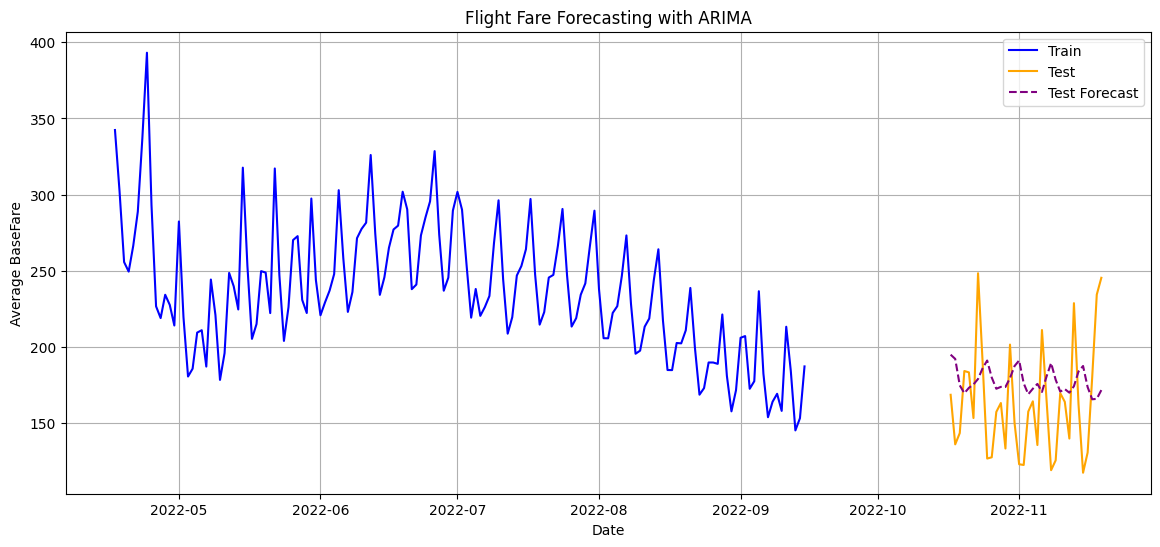

In [ ]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Fit ARIMA on training data
model = auto_arima(
    y_train,
    seasonal=True,
    m=31,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Forecast for test set
n_test = len(y_test)
test_forecast = model.predict(n_periods=n_test)

# Evaluate on test set
print("Test Metrics:")
print(f"Test MSE: {mean_squared_error(y_test, test_forecast):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, test_forecast):.4f}")
print(f"Test R²: {r2_score(y_test, test_forecast):.4f}")

# Plot
plt.figure(figsize=(14,6))

plt.plot(X_train, y_train, label='Train', color='blue')
plt.plot(X_test, y_test, label='Test', color='orange')

plt.plot(X_test, test_forecast, '--', label='Test Forecast', color='purple')

plt.title('Flight Fare Forecasting with ARIMA')
plt.xlabel('Date')
plt.ylabel('Average BaseFare')
plt.legend()
plt.grid()
plt.show()

## Baseline 2: XGBoost

In [ ]:
!ls /Users/FionaXu/Documents/Wellesley/Academics/CleanAIT/AIT-DeepLearning-Project/chunks
!pip install xgboost

test  train val
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 1.6 MB/s eta 0:00:00a 0:00:010m


In [ ]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Prepare data
base_dir = os.getcwd()
train_chunk_dir = os.path.join(base_dir, "chunks", "train")
val_chunk_dir = os.path.join(base_dir, "chunks", "val")
test_chunk_dir = os.path.join(base_dir, "chunks", "test")

train_chunks = sorted([
    os.path.join(train_chunk_dir, f) for f in os.listdir(train_chunk_dir) if f.endswith(".parquet")
])
val_chunks = sorted([
    os.path.join(val_chunk_dir, f) for f in os.listdir(val_chunk_dir) if f.endswith(".parquet")
])
test_chunks = sorted([
    os.path.join(test_chunk_dir, f) for f in os.listdir(test_chunk_dir) if f.endswith(".parquet")
])

train_gen = ChunkedFlightGenerator(train_chunks)
val_gen = ChunkedFlightGenerator(val_chunks)
test_gen = ChunkedFlightGenerator(test_chunks)

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50)
X_train = train_gen.X
y_train = train_gen.y

X_val = val_gen.X
y_val = val_gen.y



reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],

       verbose=100)

[0]	validation_0-rmse:132.94812	validation_1-rmse:111.66591
[100]	validation_0-rmse:85.10060	validation_1-rmse:78.27332
[200]	validation_0-rmse:81.82455	validation_1-rmse:76.30521
[300]	validation_0-rmse:79.83114	validation_1-rmse:75.12094
[400]	validation_0-rmse:78.50913	validation_1-rmse:74.35494
[500]	validation_0-rmse:77.48806	validation_1-rmse:74.00978
[600]	validation_0-rmse:76.66804	validation_1-rmse:73.55495
[700]	validation_0-rmse:76.04662	validation_1-rmse:73.32736
[800]	validation_0-rmse:75.43659	validation_1-rmse:73.15420
[900]	validation_0-rmse:74.96725	validation_1-rmse:72.96308
[999]	validation_0-rmse:74.55756	validation_1-rmse:72.83462


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions
y_train_pred = reg.predict(X_train)
y_val_pred = reg.predict(X_val)

# Calculate metrics for training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for validation set
val_mse = mean_squared_error(y_val, y_val_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Train MSE: {train_mse:.2f}")
print(f"Train MAE: {train_mae:.2f}")
print(f"Train R2: {train_r2:.4f}")

print(f"Validation MSE: {val_mse:.2f}")
print(f"Validation MAE: {val_mae:.2f}")
print(f"Validation R2: {val_r2:.4f}")

Train MSE: 5558.83
Train MAE: 44.66
Train R2: 0.7681
Validation MSE: 5304.88
Validation MAE: 43.87
Validation R2: 0.6505


1


## Simple RNN

In [ ]:
# Prepare data
base_dir = os.getcwd()
train_chunk_dir = os.path.join(base_dir, "chunks", "train")
val_chunk_dir = os.path.join(base_dir, "chunks", "val")
test_chunk_dir = os.path.join(base_dir, "chunks", "test")

train_chunks = sorted([
    os.path.join(train_chunk_dir, f) for f in os.listdir(train_chunk_dir) if f.endswith(".parquet")
])
val_chunks = sorted([
    os.path.join(val_chunk_dir, f) for f in os.listdir(val_chunk_dir) if f.endswith(".parquet")
])
test_chunks = sorted([
    os.path.join(test_chunk_dir, f) for f in os.listdir(test_chunk_dir) if f.endswith(".parquet")
])

train_gen = ChunkedFlightGenerator(train_chunks)
val_gen = ChunkedFlightGenerator(val_chunks)
test_gen = ChunkedFlightGenerator(test_chunks)

In [ ]:
model = Sequential([
    SimpleRNN(16, input_shape=(1, train_gen.X.shape[1])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

model.fit(train_gen, validation_data=val_gen, epochs=5)

predictions = model.predict(test_gen, batch_size=128)
y_true = np.concatenate(
    [test_gen[i][1] for i in range(len(test_gen))],
    axis=0
)

print(f"Test MSE: {mean_squared_error(y_true, predictions):.4f}")
print(f"Test MAE: {mean_absolute_error(y_true, predictions):.4f}")
print(f"Test R²: {r2_score(y_true, predictions):.4f}")

Epoch 1/5


/Users/hpanh/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/hpanh/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


742753/742753 ━━━━━━━━━━━━━━━━━━━━ 668s 898us/step - loss: 26025.8164 - val_loss: 14851.0352
Epoch 2/5
742753/742753 ━━━━━━━━━━━━━━━━━━━━ 650s 875us/step - loss: 18830.6934 - val_loss: 14194.5537
Epoch 3/5
742753/742753 ━━━━━━━━━━━━━━━━━━━━ 665s 894us/step - loss: 17291.7559 - val_loss: 13641.6836
Epoch 4/5
742753/742753 ━━━━━━━━━━━━━━━━━━━━ 661s 890us/step - loss: 17177.0996 - val_loss: 13826.0449
Epoch 5/5
742753/742753 ━━━━━━━━━━━━━━━━━━━━ 763s 1ms/step - loss: 16935.3184 - val_loss: 13769.9219
49114/49114 ━━━━━━━━━━━━━━━━━━━━ 33s 669us/step
Test MSE: 11205.9932
Test MAE: 83.0002
Test R²: -0.1239


## LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import r2_score

In [ ]:
time_feature_indices = [12, 13, 14]

# Select only the time features
X_train_time = X_train[:, time_feature_indices]
X_val_time = X_val[:, time_feature_indices]

In [ ]:
print(X_train_time.shape)
print(X_train.shape)

(23768082, 3, 1)
(23768082, 55)


In [ ]:
n_steps = 55      # because you have 3 time-related features
n_features = 1  # because you have 55 features, including time-related ones

X_train_lstm= X_train.reshape((X_train.shape[0], n_steps, n_features))
X_val_lstm = X_val.reshape((X_val.shape[0], n_steps, n_features))

In [ ]:

model = Sequential()
model.add(LSTM(50, activation='relu', dropout=0.3, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

In [ ]:
# Train
model.fit(
    X_train_time,y_train,
    epochs=3,
    verbose=1,
    validation_data=(X_val_time, y_val))

# After training
y_pred = model.predict(X_val_time)
r2 = r2_score(y_val, y_pred)
print("R² Score:", r2)

Epoch 1/3
742753/742753 ━━━━━━━━━━━━━━━━━━━━ 976s 1ms/step - loss: 23784.2402 - mae: 103.6707 - mse: 23784.2402 - val_loss: 20160.6797 - val_mae: 110.5064 - val_mse: 20160.6797
Epoch 2/3
742753/742753 ━━━━━━━━━━━━━━━━━━━━ 991s 1ms/step - loss: 22837.7617 - mae: 101.6054 - mse: 22837.7617 - val_loss: 20494.2285 - val_mae: 110.9393 - val_mse: 20494.2285
Epoch 3/3
742753/742753 ━━━━━━━━━━━━━━━━━━━━ 1076s 1ms/step - loss: 22848.5918 - mae: 101.6242 - mse: 22848.5918 - val_loss: 19966.8242 - val_mae: 109.2547 - val_mse: 19966.8242
164111/164111 ━━━━━━━━━━━━━━━━━━━━ 58s 354us/step
R² Score: -0.3154878616333008


## GRU

In [ ]:
# Prepare data
base_dir = os.getcwd()
base_dir = "/Users/sadimaharjan/Desktop/AIT-DeepLearning-Project"
print(base_dir)

train_chunk_dir = os.path.join(base_dir, "chunks", "train")
val_chunk_dir = os.path.join(base_dir, "chunks", "val")
test_chunk_dir = os.path.join(base_dir, "chunks", "test")

train_chunks = sorted([
    os.path.join(train_chunk_dir, f) for f in os.listdir(train_chunk_dir) if f.endswith(".parquet")
])
val_chunks = sorted([
    os.path.join(val_chunk_dir, f) for f in os.listdir(val_chunk_dir) if f.endswith(".parquet")
])
test_chunks = sorted([
    os.path.join(test_chunk_dir, f) for f in os.listdir(test_chunk_dir) if f.endswith(".parquet")
])

train_gen = ChunkedFlightGenerator(train_chunks)
val_gen = ChunkedFlightGenerator(val_chunks)
test_gen = ChunkedFlightGenerator(test_chunks)  # Prepare data

/Users/sadimaharjan/Desktop/AIT-DeepLearning-Project


In [ ]:
from tensorflow.keras.layers import GRU

# Define GRU model
model = Sequential([
    GRU(16, input_shape=(1, train_gen.X.shape[1])),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(train_gen, validation_data=val_gen, epochs=5)

# Predict
predictions = model.predict(test_gen, batch_size=128)

# Evaluate
y_true = np.concatenate(
    [test_gen[i][1] for i in range(len(test_gen))],
    axis=0
)

print(f"Test MSE: {mean_squared_error(y_true, predictions):.4f}")
print(f"Test MAE: {mean_absolute_error(y_true, predictions):.4f}")
print(f"Test R²: {r2_score(y_true, predictions):.4f}")


Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


742753/742753 ━━━━━━━━━━━━━━━━━━━━ 649s 873us/step - loss: 21267.4277 - val_loss: 12485.8828
Epoch 2/5
742753/742753 ━━━━━━━━━━━━━━━━━━━━ 617s 830us/step - loss: 15894.0615 - val_loss: 12366.8896
Epoch 3/5
742753/742753 ━━━━━━━━━━━━━━━━━━━━ 527s 709us/step - loss: 15759.9736 - val_loss: 13088.0557
Epoch 4/5
742753/742753 ━━━━━━━━━━━━━━━━━━━━ 505s 679us/step - loss: 15626.9609 - val_loss: 12634.1787
Epoch 5/5
742753/742753 ━━━━━━━━━━━━━━━━━━━━ 431s 579us/step - loss: 15668.4092 - val_loss: 12754.2910
49114/49114 ━━━━━━━━━━━━━━━━━━━━ 12s 240us/step
Test MSE: 9547.2490
Test MAE: 71.3683
Test R²: 0.0424
